# Modelo de Predição de Sucessos Spotify

Esse projeto tem como finalidade o desenvolvimento de um modelo preditivo capaz de analisar músicas do aplicativo e determinar se elas vão ser bem-sucedidas.

Primeiro vamos instalar e importar as bibliotecas usadas

In [1]:
%pip install pandas numpy seaborn scikit-learn matplotlib tabulate

import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from sklearn.model_selection import RandomizedSearchCV # type: ignore

Note: you may need to restart the kernel to use updated packages.


Depois vamos abrir os arquivos que iremos usar

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
3,16326,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,109799,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0


### Exploração dos dados

Nesse momento, faremos uma análise dos dados para determinar se existem problemas na base de treinamento.

##### identificação de duplicatas

In [3]:
# Check for duplicates based on 'track_id' and 'track_name'
duplicate_rows = df_train[df_train.duplicated(subset=['track_id', 'track_name'])]
duplicate_count = duplicate_rows.shape[0]

print(f"Number of duplicate rows: {duplicate_count}")
# Display the duplicates if found
if duplicate_count > 0:
    display(duplicate_rows.head())

Number of duplicate rows: 13080


,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
797,72032,1yc53HK08sDab7PDFgnLWk,Lamb of God,Ashes of the Wake (15th Anniversary),Laid to Rest,230127,True,0.366,0.956,10,...,0,0.1080,0.000293,0.004470,0.4490,0.1590,104.016,3,metalcore,1
835,21056,51p7NpYENytr1NyYJSP2M3,Charly Black,Rio Bueno,You're Perfect,196946,False,0.757,0.842,7,...,0,0.2420,0.313000,0.000000,0.0541,0.8260,104.832,4,dancehall,1
879,68048,5ElpusNZMl7iKKmVuxC6EH,Feid;J Balvin;Maluma;Nicky Jam;Sech;Justin Quiles,Verano en Junio,PORFA - Remix,333800,True,0.793,0.737,6,...,0,0.0785,0.076500,0.000000,0.0747,0.6970,167.969,4,latino,0
1435,8297,6AJrjScRxKAzfImtWbCIaM,Thin Lizzy,Rock Workout 2023,The Boys Are Back In Town,263146,False,0.457,0.870,8,...,1,0.0711,0.292000,0.000002,0.1170,0.6940,81.095,4,blues,0
1493,73152,3BfLcQOyP6ovmQFTYfhIx4,Oliver Huntemann,Nordpol / Südpol,Nordpol,400101,False,0.778,0.864,7,...,1,0.0413,0.007240,0.895000,0.0952,0.0275,126.008,4,minimal-techno,1


#### identificação de outliers

Ao utilizar os gráficos boxplot abaixo, somos capazes de visualizar como os valores se comportam nos casos de músicas bem-sucedidas e no geral, criando uma visualização das relações desejadas.

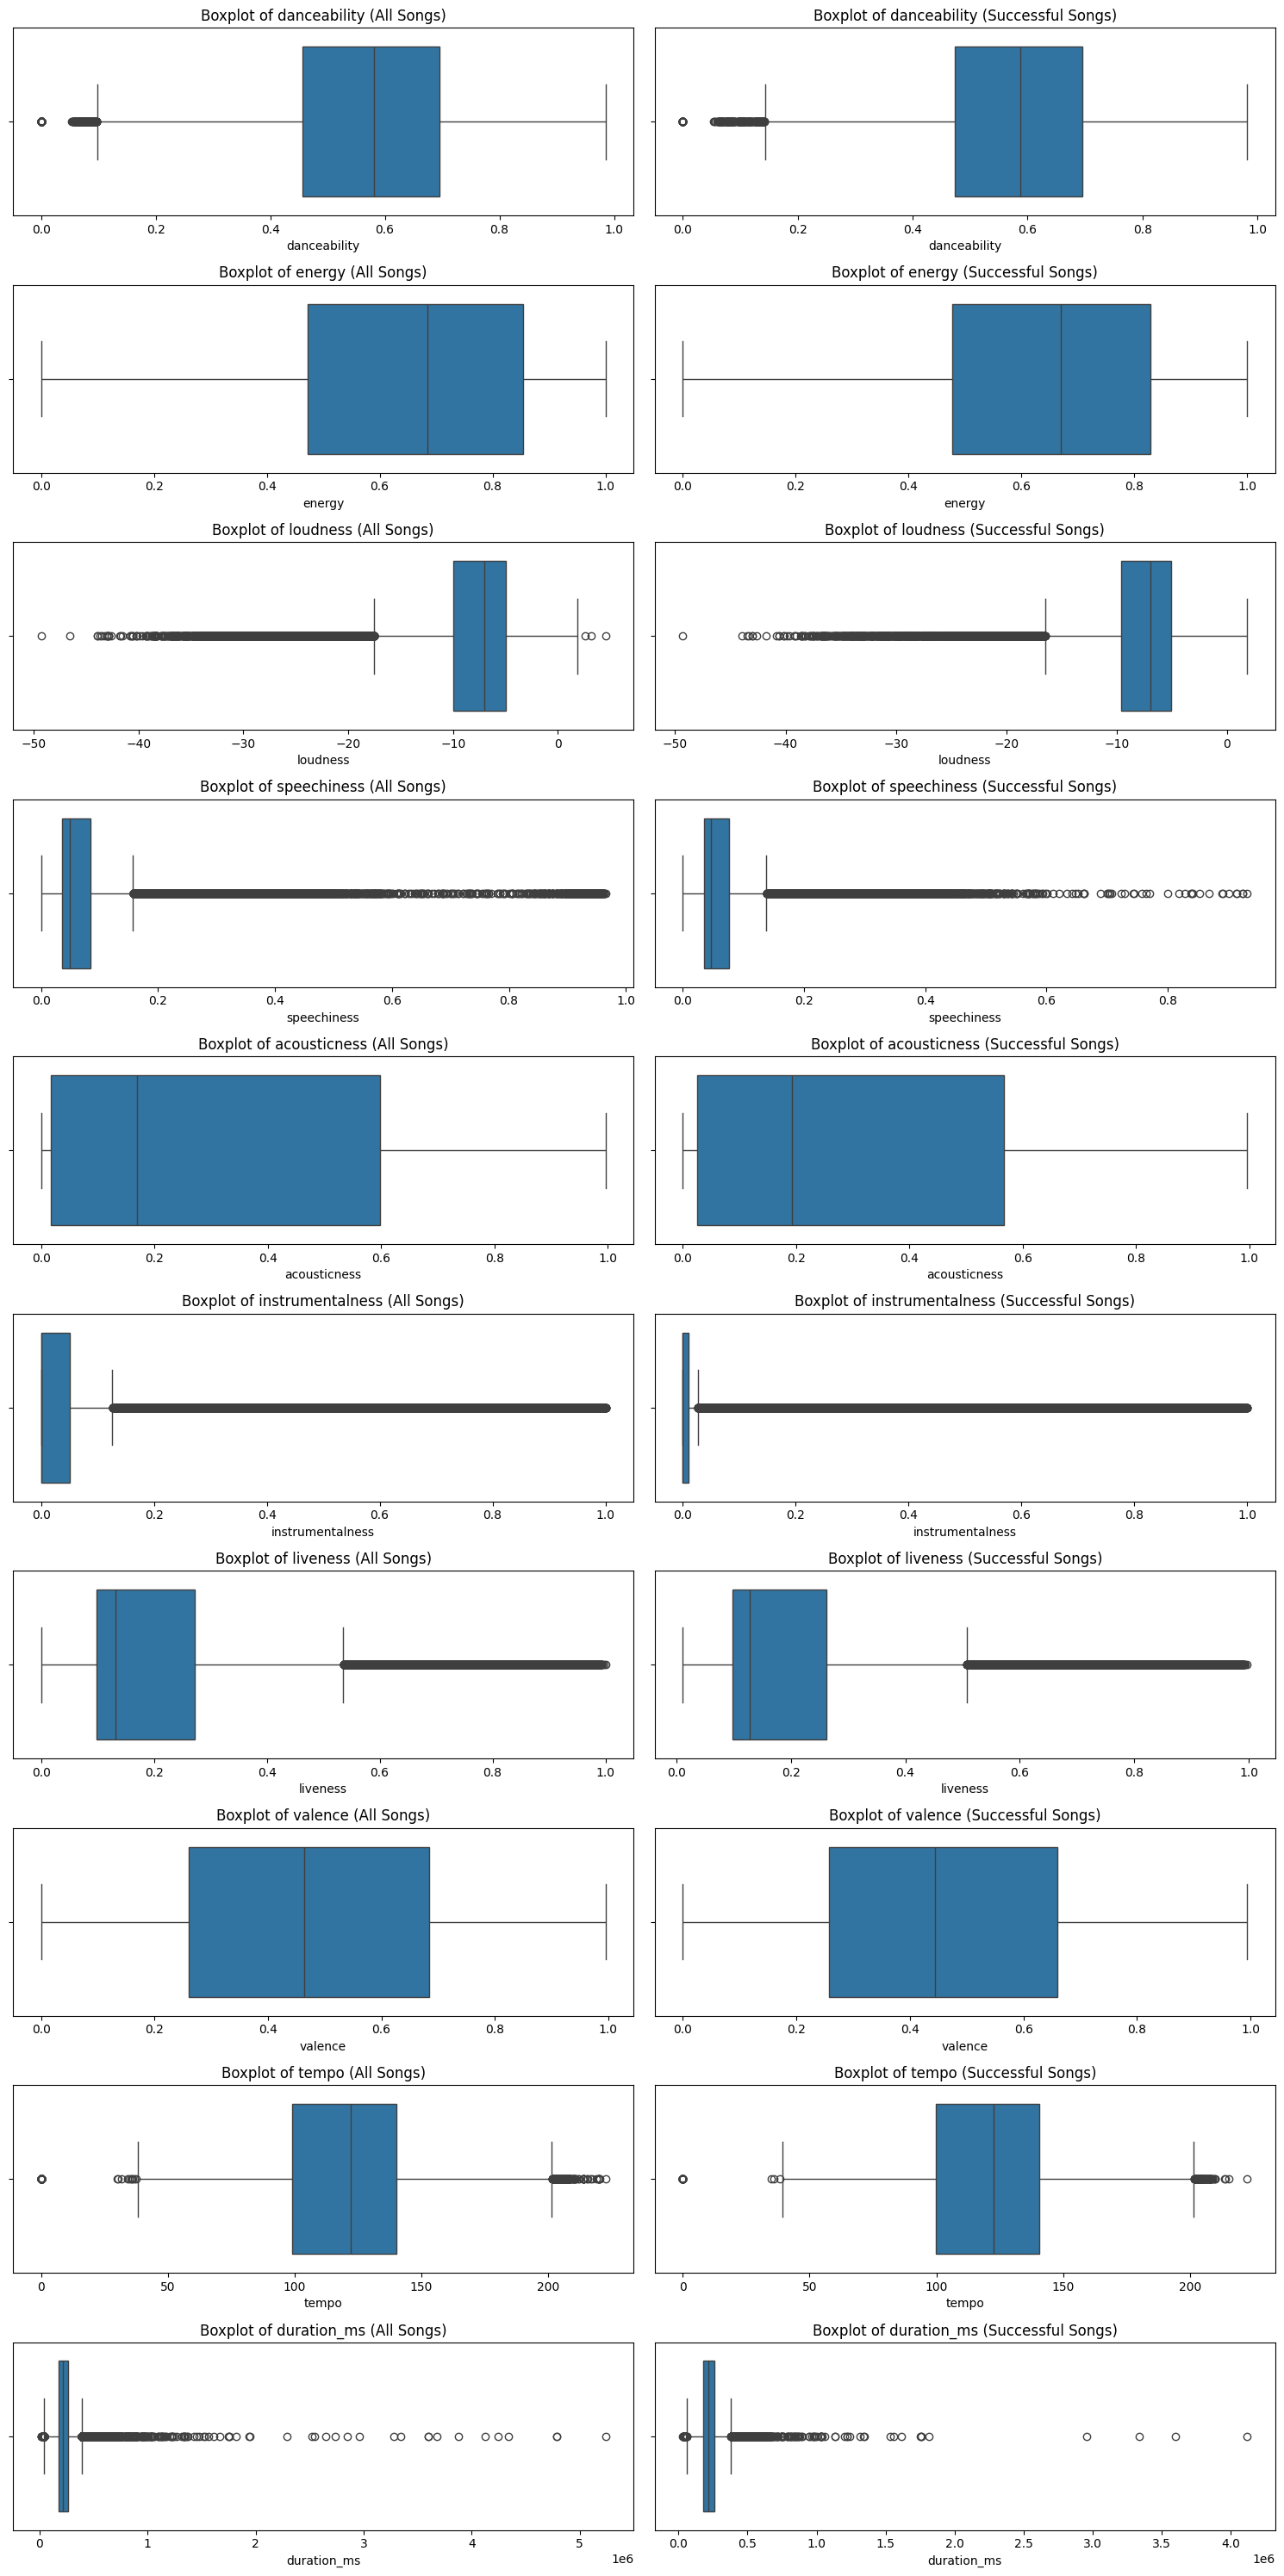

In [4]:
# Filter dataset for only successful songs (popularity_target == 1)
successful_songs = df_train[df_train['popularity_target'] == 1]

# Define the numeric columns
numeric_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                   'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Plot side-by-side boxplots for all songs and successful songs
plt.figure(figsize=(15, 30))  # Adjust the size to accommodate the double plots

for i, col in enumerate(numeric_columns):
    # Boxplot for all songs (left)
    plt.subplot(len(numeric_columns), 2, 2 * i + 1)
    sns.boxplot(x=df_train[col])
    plt.title(f"Boxplot of {col} (All Songs)")

    # Boxplot for successful songs (right)
    plt.subplot(len(numeric_columns), 2, 2 * i + 2)
    sns.boxplot(x=successful_songs[col])
    plt.title(f"Boxplot of {col} (Successful Songs)")

plt.tight_layout()
plt.show()

Identificação da quantidade de músicas de sucesso para os top 20 gêneros.

<Figure size 1400x800 with 0 Axes>

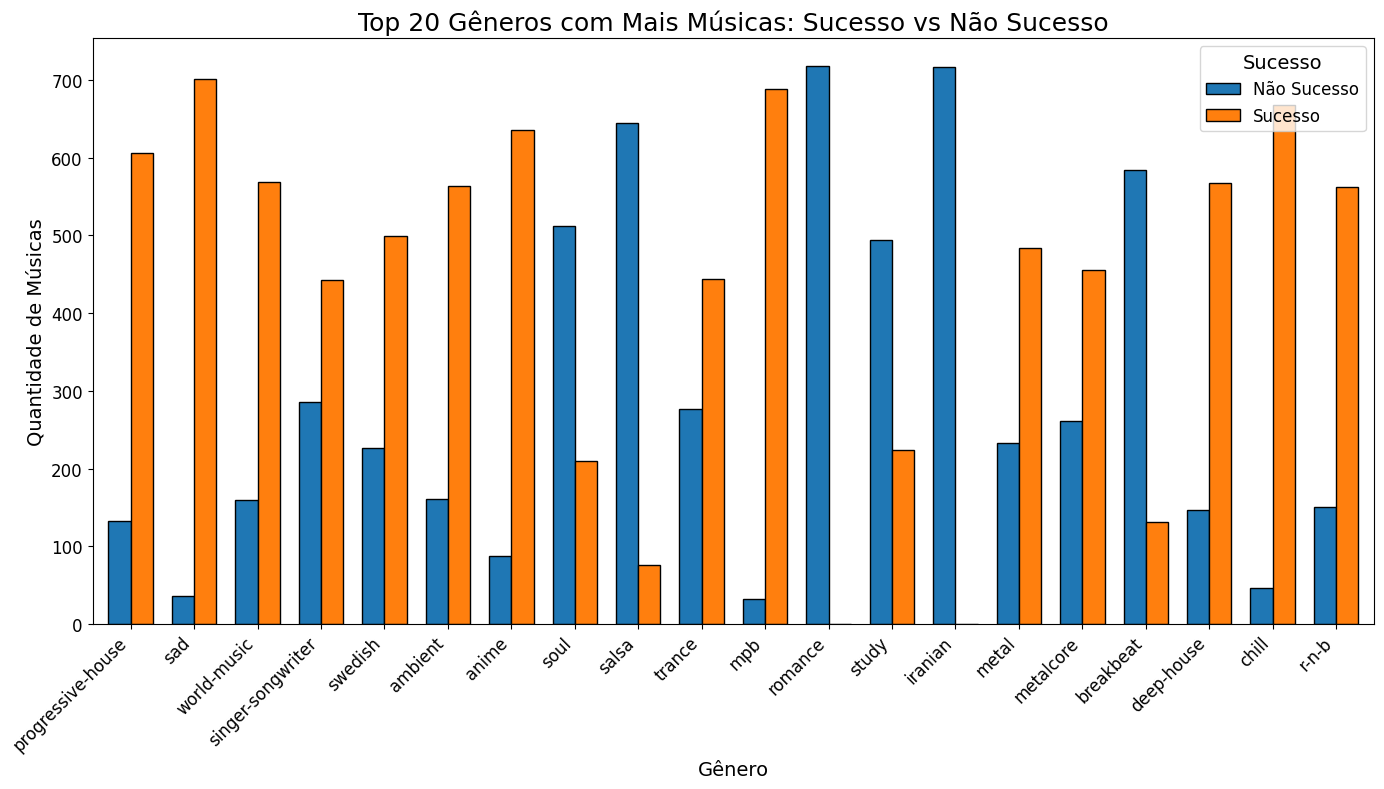

In [5]:
# Agrupar por gênero e status de sucesso
genre_grouped = df_train.groupby(['track_genre', 'popularity_target']).size().unstack().fillna(0)

# Pegar os top 20 gêneros com mais músicas
top_genres = genre_grouped.sum(axis=1).sort_values(ascending=False).head(20).index

# Filtrar o DataFrame pelos top 20 gêneros
top_genre_grouped = genre_grouped.loc[top_genres]

# Plotar gráfico de barras com os top 20 gêneros
plt.figure(figsize=(14, 8))
top_genre_grouped.plot(kind='bar', figsize=(14, 8), width=0.7, edgecolor='black')

# Adicionar título e rótulos
plt.title('Top 20 Gêneros com Mais Músicas: Sucesso vs Não Sucesso', fontsize=18)
plt.xlabel('Gênero', fontsize=14)
plt.ylabel('Quantidade de Músicas', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sucesso', labels=['Não Sucesso', 'Sucesso'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

### Criação de Hipóteses

Ao analisar o gráfico acima, podemos criar algumas hipóteses sobre os dados:

- Quanto mais vocal e menos acústica a música, maior a proporção de sucessos para fracassos.
- Músicas com energia média-alta tendem a ser bem sucedidas.
- Se a música estiver localizada com intensidade entre -10 e 0 fazem sucesso.
- Os top 5 gêneros de maior sucesso são "gospel", "sad", "forro", "turkish", "mpb".

### Limpeza dos dados

A fim de manter a o comportamento dos dados das músicas de sucesso, realizei uma remoção de outliers com base na análise dos resultados de sucesso, por meio da função abaixo:

In [6]:
def remove_outliers_based_on_success(df, success_df, columns):
    df_filtered = df.copy()
    
    for col in columns:
        # Calcular o IQR das músicas de sucesso
        Q1_success = success_df[col].quantile(0.25)
        Q3_success = success_df[col].quantile(0.75)
        IQR_success = Q3_success - Q1_success
        
        # Definir limites com base no IQR das músicas de sucesso
        lower_bound = Q1_success - 1.5 * IQR_success
        upper_bound = Q3_success + 1.5 * IQR_success
        
        # Filtrar os dados mantendo apenas valores dentro dos limites
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    
    return df_filtered

# Aplicar a função para remover outliers baseando-se no intervalo das músicas de sucesso
df_filtered_for_training = remove_outliers_based_on_success(df_train, successful_songs, numeric_columns)



Abaixo, a fim de manter os mesmo valores para as mesmas categorias, concatenei os df_train e df_test, para passá-los pelo labelEncoder e pelo drop das colunas inúteis (para predição) sem risco de erros. Depois separo os dataframes para seguir com o processo previsto.

In [7]:
# Concatenar os DataFrames
df_combined = pd.concat([df_filtered_for_training, df_test], ignore_index=True, axis=0)

# Dropar colunas irrelevantes
irrelevant_columns = ['track_id', 'track_name']
df_filtered_for_training = df_combined.drop(columns=irrelevant_columns)

# Identificar colunas categóricas
categorical_columns = ['track_unique_id', 'artists', 'album_name', 'explicit', 'key', 'mode', 'track_genre']

# Aplicar Label Encoding nas colunas categóricas
for col in categorical_columns:
    df_filtered_for_training[col] = LabelEncoder().fit_transform(df_filtered_for_training[col])
    
# Separar os DataFrames novamente
df_train_encoded = df_filtered_for_training.iloc[:43286].reset_index(drop=True)
df_test_encoded = df_filtered_for_training.iloc[43286:].reset_index(drop=True)

In [8]:
df_train_encoded.tail()

,track_unique_id,artists,album_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
43281,28470,14935,19017,255080,0,0.436,0.876,10,-4.902,0,0.0647,0.000033,0.000104,0.2050,0.512,157.044,4,44,1.0
43282,59050,9890,19425,145449,0,0.656,0.618,5,-8.776,1,0.0493,0.392000,0.000003,0.1010,0.953,96.041,4,87,1.0
43283,24181,13320,5585,205133,0,0.309,0.564,6,-6.955,0,0.0380,0.119000,0.001750,0.1110,0.488,179.106,3,37,0.0
43284,71125,7323,17632,136306,0,0.629,0.560,0,-11.455,0,0.0523,0.595000,0.000000,0.1820,0.880,118.895,3,103,0.0
43285,769,20429,13070,216841,0,0.421,0.107,6,-15.191,1,0.0335,0.948000,0.000000,0.0881,0.118,104.218,4,0,1.0


### Implementação e treinamento do modelo

Nessa etapa, separamos dados de treino e teste usando *train_test_spliter* e fazendo o treinamento com Random Forest Classifier, medindo sua acurácia e demonstrando isso por meio de uma matriz de confusão.

In [9]:
# Separar as variáveis independentes (X) e dependente (y)
X = df_train_encoded.drop(columns=['popularity_target'])
y = df_train_encoded['popularity_target']

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir o modelo Random Forest
model = RandomForestClassifier()

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Medição da acurácia do modelo
accuracy = accuracy_score(np.round(y_test), np.round(y_pred))
print(f"Acurácia do modelo de Random Forest: {accuracy:.2f}")

Acurácia do modelo de Random Forest: 0.84


### Avaliação dos Resultados

Podemos visualizar a eficiência do modelo por meio de uma matriz de confusão:

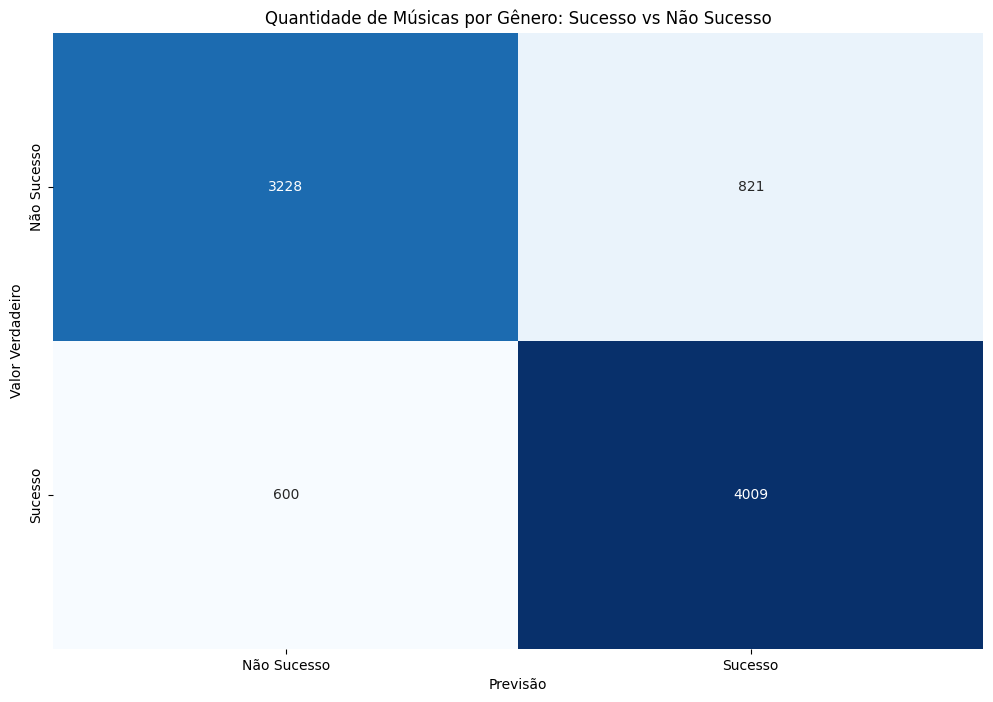

In [10]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a visualização da matriz de confusão
plt.figure(figsize=(12,8))
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar=False)

# Configurar os rótulos e títulos
plt.title('Quantidade de Músicas por Gênero: Sucesso vs Não Sucesso')
plt.xlabel('Previsão')
plt.ylabel('Valor Verdadeiro')

# Definir os rótulos das categorias (opcional, substitua conforme necessário)
plt.xticks(ticks=[0.5, 1.5], labels=['Não Sucesso', 'Sucesso'])
plt.yticks(ticks=[0.5, 1.5], labels=['Não Sucesso', 'Sucesso'])

# Exibir a matriz de confusão
plt.show()

### Tunning e Hiperparâmetros

In [11]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [100, 200, 300, 400], # Número de árvores na floresta
    'max_depth': [10, 20, 30, 40, None], # Profundidade máxima de cada árvore
    'min_samples_split': [2, 5], # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4], # Número mínimo de amostras necessárias em uma folha
    'max_features': ['log2', 'sqrt'], # Número de recursos a serem considerados para a melhor divisão
    'bootstrap': [True, False] # Se deve usar amostragem com reposição
}

# Configurar o Grid Search com validação cruzada
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                           cv=10, n_jobs=-1, verbose=1, scoring='accuracy')

# Executar o Grid Search no conjunto de treino
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid_search.best_params_)

# Treinar o modelo com os melhores hiperparâmetros encontrados
best_model = grid_search.best_estimator_

# Fazer previsões no conjunto de teste
y_pred_best_model = best_model.predict(X_test)

# Avaliar a acurácia do modelo com os melhores hiperparâmetros
accuracy = accuracy_score(y_test, y_pred_best_model)
print(f"Acurácia do modelo otimizado: {accuracy:.2f}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

### Nova Avaliação do modelo

Por fim vamos recriar as matrizes de confusão do modelo inicial e do modelo com *tunnings*:

In [ ]:
# Calcular as matrizes de confusão
cm_old = confusion_matrix(y_test, y_pred)
cm_new = confusion_matrix(y_test, y_pred_best_model)

# Criar as figuras para as matrizes de confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Exibir a matriz de confusão do modelo antigo
disp_old = ConfusionMatrixDisplay(confusion_matrix=cm_old, display_labels=['Não Sucesso', 'Sucesso'])
disp_old.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title('Matriz de Confusão - Modelo Antigo')

# Exibir a matriz de confusão do modelo otimizado
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=['Não Sucesso', 'Sucesso'])
disp_new.plot(ax=ax[1], cmap=plt.cm.Blues)
ax[1].set_title('Matriz de Confusão - Modelo Otimizado')

# Exibir as matrizes de confusão
plt.tight_layout()
plt.show()

### Envio dos resultados

Por fim, basta que importemos o resultado final para avaliação no Kaggle

In [37]:
X_test = df_test_encoded.drop(columns=['popularity_target'])

# Fazer previsões no conjunto de teste
y_pred2 = model.predict(X_test)

# Salvar os valores preditos em um dataframe
resultados = pd.DataFrame({
    'track_unique_id': df_test['track_unique_id'],
    'popularity_prediction': y_pred2
})

# Salvar as previsões em um arquivo CSV
resultados.to_csv('submission.csv', index=False)